<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
Sharif University of Technology, CE department
</font>
<br>
<br>
<font size=6>
Homework 2
</font><br>
<font size=4>
AlexNet - MRI Classification
</font>

**First-Name: Amir Mohammad**

**Last-Name: Ezzati**

**Student-Id: 402212269**

## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/SPB/HW2/data/"

Mounted at /content/drive


In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=e9ba4ec04610ac29778b61e47c4d60712b88fd8c180b66ef087c96602614d794
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [3]:
import os
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import torch
import random
import pandas as pd
import random
import glob
import sklearn as sk
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from IPython.display import display
import torch
from torch import nn, optim
from torch.nn import Sequential
from torch.optim import Optimizer, Adam
from torch.utils.data import DataLoader, Dataset, Sampler
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image
from torchvision import transforms as t
from torchvision.transforms import functional as F
from torch.optim import lr_scheduler
import wandb
import IPython
import math

In [4]:
# !wandb login --relogin --host=http://wandb.your-shared-local-host.com

In [5]:
wandb.login(key='f63f6bf237335da137544dff247f145d2db7f47a')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# read dataset and show classes

In [6]:
import pickle
def read_from_pickle(path):
  pfile = open(path, 'rb')
  return pd.read_pickle(pfile)

train_path = data_path + 'train.pickle'
val_path = data_path + 'validation.pickle'
test_path = data_path + 'test.pickle'

trainset = np.array(read_from_pickle(train_path))
valset = np.array(read_from_pickle(val_path))
testset = np.array(read_from_pickle(test_path))

<ipython-input-6-fb36756d86ac>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trainset = np.array(read_from_pickle(train_path))
<ipython-input-6-fb36756d86ac>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  valset = np.array(read_from_pickle(val_path))
<ipython-input-6-fb36756d86ac>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarra

In [7]:
classes = np.unique(trainset[:, 1])
classes

array([1, 2, 3], dtype=object)

In [8]:
def changeClassIndices(dataset):
  for i in range(len(dataset[:, 1])):
    if dataset[i, 1] == 1:
      dataset[i, 1] = 0
    elif dataset[i, 1] == 2:
      dataset[i, 1] = 1
    elif dataset[i, 1] == 3:
      dataset[i, 1] = 2

changeClassIndices(trainset)
changeClassIndices(valset)
changeClassIndices(testset)

In [9]:
testset.shape

(307, 2)

In [10]:
classes = np.unique(trainset[:, 1])
classes

array([0, 1, 2], dtype=object)

In [11]:
class_names =  ['Ⅿeningioⅿa', 'Gⅼioⅿa', 'Pitutary'] # 0 1 2

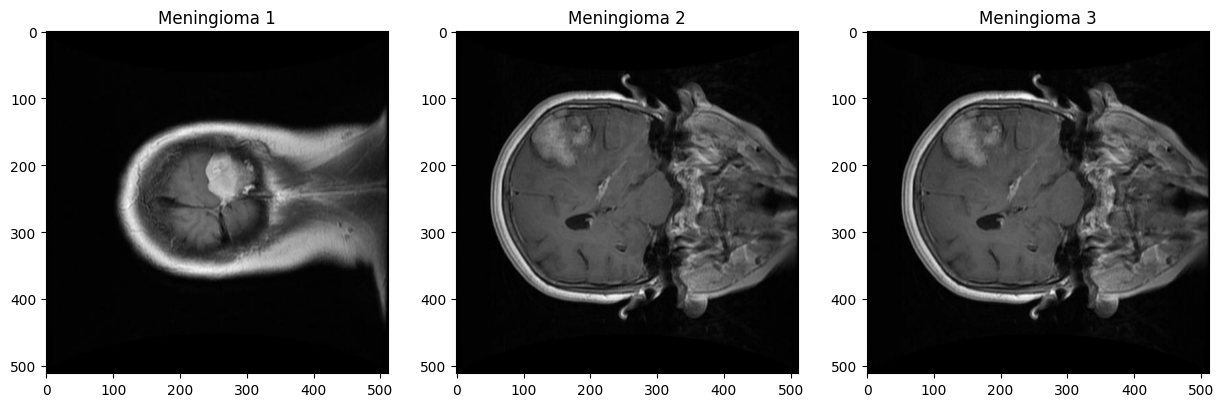

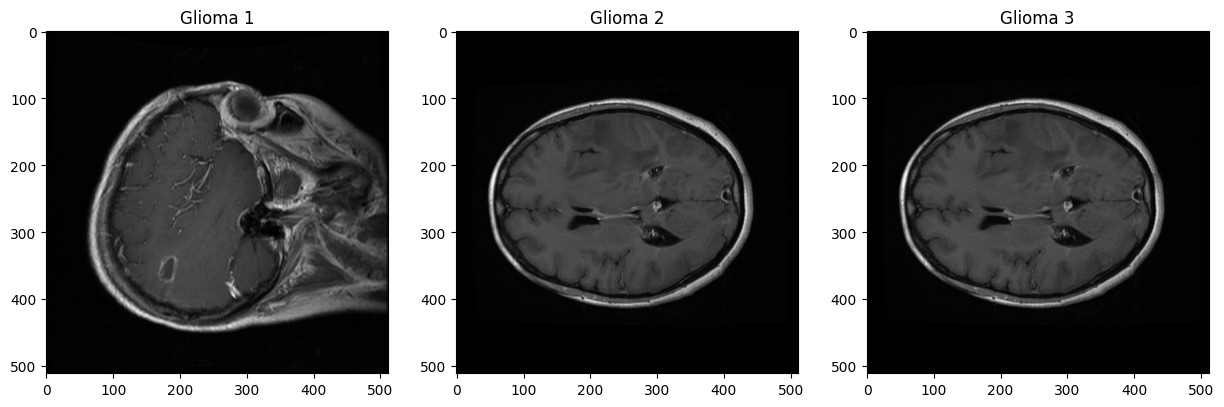

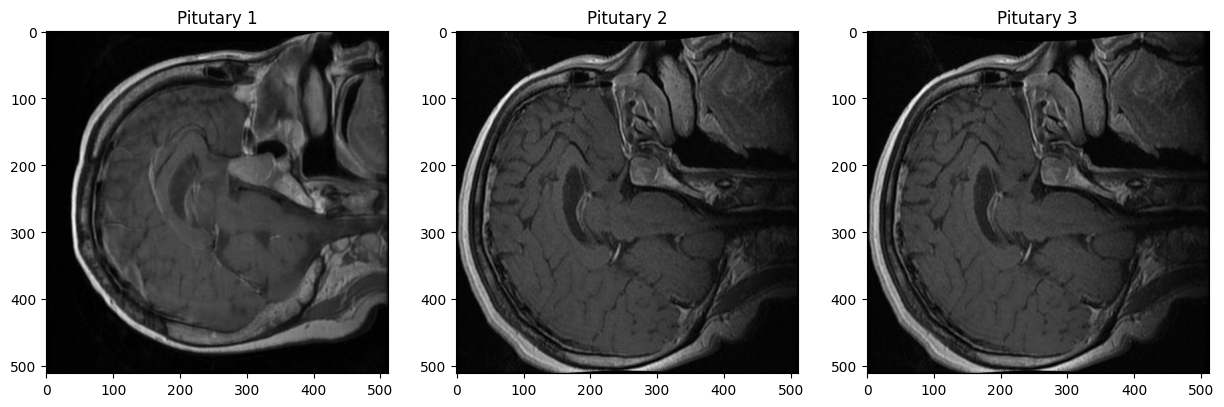

In [12]:
def showSamples(dataset, class_ = 0):
  indices = np.where(dataset[:,1] == class_)
  selected_samples = dataset[np.random.choice(indices[0], 3)]

  fig,axs = plt.subplots(1,3, figsize=(15,15))
  axs[0].title.set_text(class_names[class_] + ' 1')
  axs[0].imshow(selected_samples[0][0])
  axs[1].title.set_text(class_names[class_] + ' 2')
  axs[1].imshow(selected_samples[2][0], cmap='gray')
  axs[2].title.set_text(class_names[class_] + ' 3')
  axs[2].imshow(selected_samples[2][0])

showSamples(trainset, class_=0)
showSamples(trainset, class_=1)
showSamples(trainset, class_=2)

# Dataset

In [13]:
import torchvision
transform = t.Compose([
    torchvision.transforms.ToTensor(),
])

In [14]:
class DatasetPair(Dataset):
  def __init__(self, x, y, transform=transform, twoCropTransform=None):
    self.img_labels = y
    self.imgs = x
    self.transform = transform
    self.twoCropTransform = twoCropTransform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = self.imgs[idx]
    label = self.img_labels[idx]

    if self.twoCropTransform:
      image = self.twoCropTransform(image)
    else:
      image = self.transform(image)
    return image, label

In [15]:
train_dataset = DatasetPair(trainset[:, 0], trainset[:, 1])
val_dataset = DatasetPair(valset[:, 0], valset[:, 1])
test_dataset = DatasetPair(testset[:, 0], testset[:, 1])

In [16]:
print('x_train.shape: ', train_dataset.imgs.shape)
print('x_val.shape: ', val_dataset.imgs.shape)
print('x_test.shape: ', test_dataset.imgs.shape)
print('y_train.shape: ', train_dataset.img_labels.shape)

x_train.shape:  (2451,)
x_val.shape:  (306,)
x_test.shape:  (307,)
y_train.shape:  (2451,)


# Useful Functions
  **Training and validating one epoch - Evaluate**

In [49]:
from sklearn import metrics

def train_one_epoch(model, loader, criterion, optimizer, history, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_accuracy += metrics.accuracy_score(labels.cpu(), preds.cpu())

    loss = running_loss / len(loader)
    accuracy = running_accuracy / len(loader)

    history['acc'].append(accuracy)
    history['loss'].append(loss)
    return loss, accuracy

def validate_one_epoch(model, loader, criterion, history, device):
    model.eval()

    running_loss = 0.0
    running_accuracy = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1_score = 0.0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_accuracy += metrics.accuracy_score(labels.cpu(), preds.cpu())
            running_precision += metrics.precision_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
            running_recall += metrics.recall_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
            running_f1_score += metrics.f1_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)

    loss = running_loss / len(loader)
    accuracy = running_accuracy / len(loader)
    precision = running_precision / len(loader)
    recall = running_recall / len(loader)
    f1_score = running_f1_score / len(loader)

    history['acc'].append(accuracy)
    history['loss'].append(loss)
    return loss, accuracy, precision, recall, f1_score

In [50]:
def showCharts(train_history, val_history, mode='acc'):
  epoch = np.arange(len(train_history['acc']))
  if mode == 'acc':
    plt.plot(epoch, train_history['acc'], label='train accuracy')
    plt.plot(epoch, val_history['acc'], label='validation accuracy')
    plt.ylabel('accuracy')
  elif mode == 'loss':
    plt.plot(epoch, train_history['loss'], label='train loss')
    plt.plot(epoch, val_history['loss'], label='validation loss')
    plt.ylabel('loss')

  plt.xlabel('epoch')
  plt.legend()

In [51]:
def evaluate(model, dataloader, criterion, device, history={'acc': [], 'loss': []}):
  loss, acc, precision, recall, f1 = validate_one_epoch(model, dataloader, criterion, history, device)

  print(f"Loss: {loss:.4f} - "
        f"ACC: {acc:.4f}% - "
        f"Precision: {precision:.4f}% - "
        f"Recall {recall:.4f}% - "
        f"F1 score: {f1:.2f}%")


In [52]:
def prediction(model, loader, device):
    model.eval()

    y_truth = []
    y_preds = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            y_preds.extend(preds.cpu())
            y_truth.extend(labels.cpu())

    return y_preds, y_truth

def confusionMatrix(model, dataloader, device):
  y_preds, y_truth = prediction(model, dataloader, device)

  cm = confusion_matrix(y_truth, y_preds, labels=[0, 1, 2])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=class_names)
  disp.plot()
  plt.show()

# AlexNet From Scratch

In [32]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024), # (4096, 4096) --> (4096, 1024) to avoid overfitting and heavy losses during training
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
      x = self.features(x)
      x = self.avgpool(x)
      x = x.view(-1, 256 * 6 * 6)
      x = self.classifier(x)
      return x

## Train

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# create model
alexnet = AlexNet(num_classes = 3).to(device)

In [ ]:
BATCH_SIZE = 32
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)

val_dataloader = DataLoader(
        val_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)

test_dataloader = DataLoader(
        test_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)

In [ ]:
num_epochs = 50

wandb.init(
    # set the wandb project where this run will be logged
    project="Brain MRI Classification",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": num_epochs,
    },
    name='alexnet_from_scratch'
)


train_history = {'acc': [], 'loss': []}
val_history = {'acc': [], 'loss': []}

model_path = data_path[:-5] + 'alexnet.pt'
best_valid_acc = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(alexnet, train_dataloader, criterion, optimizer, train_history, device)
    val_loss, val_acc, precision, recall, f1 = validate_one_epoch(alexnet, val_dataloader, criterion, val_history, device)

    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(alexnet, model_path)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - "
          f"Train ACC: {train_acc:.4f}% - "
          f"Validation Loss: {val_loss:.4f} - "
          f"Validation ACC: {val_acc:.4f}% - "
          f"Validation Precision: {precision:.4f}% - "
          f"Validation: Recall {recall:.4f}% - "
          f"Validation F1: {f1:.2f}%")

wandb.finish()

wandb: Currently logged in as: amirezzati. Use `wandb login --relogin` to force relogin


Epoch [1/50] - Train Loss: 1.0744 - Train ACC: 0.4806% - Validation Loss: 1.6294 - Validation ACC: 0.6340% - Validation Precision: 0.5443% - Validation: Recall 0.6340% - Validation F1: 0.55%
Epoch [2/50] - Train Loss: 0.7449 - Train ACC: 0.6589% - Validation Loss: 1.3618 - Validation ACC: 0.6642% - Validation Precision: 0.6418% - Validation: Recall 0.6642% - Validation F1: 0.62%
Epoch [3/50] - Train Loss: 0.6715 - Train ACC: 0.6818% - Validation Loss: 1.2472 - Validation ACC: 0.6781% - Validation Precision: 0.5986% - Validation: Recall 0.6781% - Validation F1: 0.61%
Epoch [4/50] - Train Loss: 0.5592 - Train ACC: 0.7417% - Validation Loss: 1.0432 - Validation ACC: 0.7934% - Validation Precision: 0.8230% - Validation: Recall 0.7934% - Validation F1: 0.79%
Epoch [5/50] - Train Loss: 0.4757 - Train ACC: 0.7867% - Validation Loss: 0.8608 - Validation ACC: 0.8128% - Validation Precision: 0.8333% - Validation: Recall 0.8128% - Validation F1: 0.81%
Epoch [6/50] - Train Loss: 0.4244 - Train ACC

train_acc,▁▃▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▆▅▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▂▅▅▆▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇█
val_loss,█▇▆▅▄▄▃▃▅▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▂▂▁▁▁▁▁▂▂
train_acc,0.98295
train_loss,0.04403
val_acc,0.93437
val_loss,0.56363


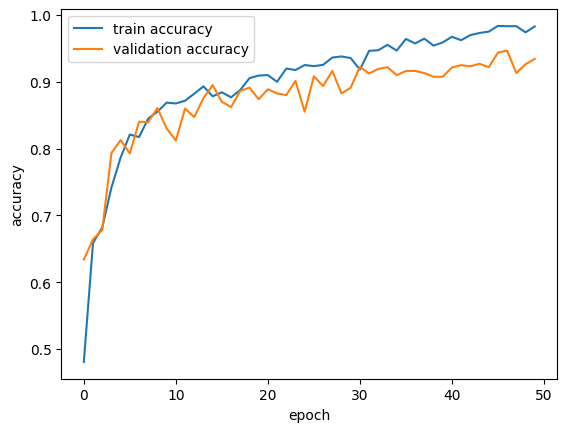

In [ ]:
showCharts(train_history, val_history, mode='acc')

In [ ]:
IPython.display.HTML('<iframe src="https://api.wandb.ai/links/amirezzati/i1o13gab" style="border:none;height:512px;width:1024px">')

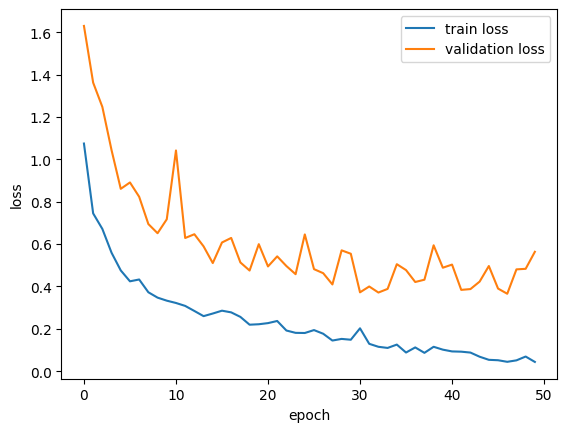

In [ ]:
showCharts(train_history, val_history, mode='loss')

In [ ]:
IPython.display.HTML('<iframe src="https://api.wandb.ai/links/amirezzati/xk994e11" style="border:none;height:512px;width:1024px">')

## evaluate the model

In [ ]:
model_path = data_path[:-5] + 'alexnet.pt'
alexnet = torch.load(model_path)

**in Trainset**


Loss: 0.0428 - ACC: 0.9959% - Precision: 0.9963% - Recall 0.9959% - F1 score: 1.00%


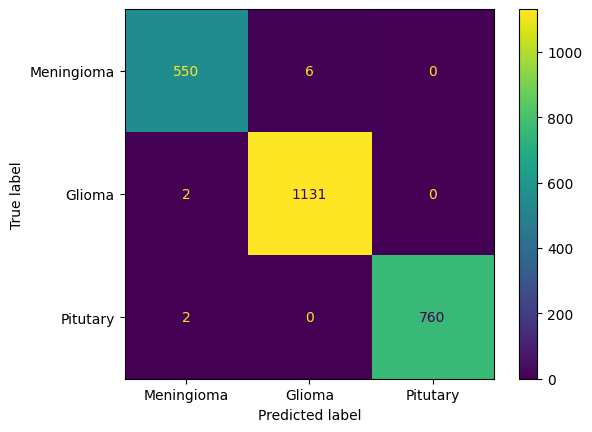

In [ ]:
evaluate(alexnet, train_dataloader, criterion, device)
confusionMatrix(alexnet, train_dataloader, device)

**in Validationset**


Loss: 0.3671 - ACC: 0.9469% - Precision: 0.9553% - Recall 0.9469% - F1 score: 0.95%


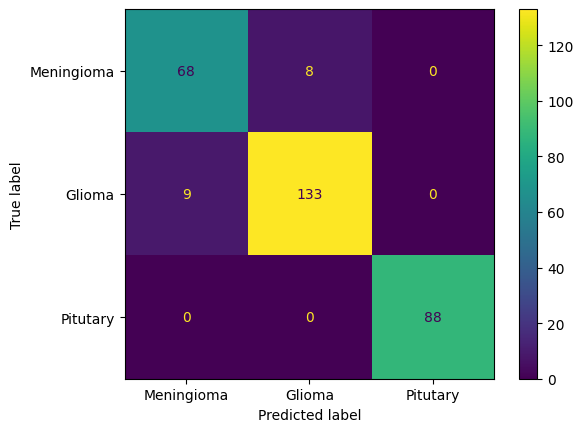

In [ ]:
evaluate(alexnet, val_dataloader, criterion, device)
confusionMatrix(alexnet, val_dataloader, device)

**in Testset**


Loss: 0.4179 - ACC: 0.9281% - Precision: 0.9324% - Recall 0.9281% - F1 score: 0.93%


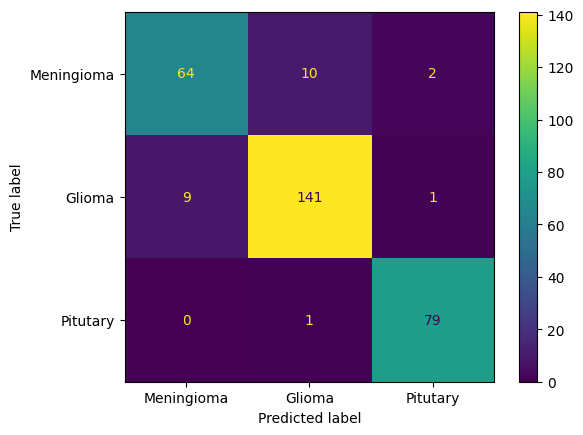

In [ ]:
evaluate(alexnet, test_dataloader, criterion, device)
confusionMatrix(alexnet, test_dataloader, device)

# Pretrained AlexNet from torchvision

In [ ]:
alexnet_t = torchvision.models.alexnet(pretrained=True)
alexnet_t.classifier[6] = nn.Linear(4096, 3)

# freeze all layer but classifier
unfreeze = ['classifier']
for layer_name, layer in alexnet_t.named_parameters():
    for name in unfreeze:
        if name in layer_name:
            layer.requires_grad = True
            break
        else:
            layer.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# create model
alexnet_t.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
BATCH_SIZE = 32
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, alexnet_t.parameters()), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)

val_dataloader = DataLoader(
        val_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)

test_dataloader = DataLoader(
        test_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)

In [ ]:
num_epochs = 20

wandb.init(
    # set the wandb project where this run will be logged
    project="Brain MRI Classification",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": num_epochs,
    },
    name='pretrained_alexnet'
)

train_history = {'acc': [], 'loss': []}
val_history = {'acc': [], 'loss': []}

model_path = data_path[:-5] + 'alexnet_t.pt'
best_valid_acc = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(alexnet_t, train_dataloader, criterion, optimizer, train_history, device)
    val_loss, val_acc, precision, recall, f1 = validate_one_epoch(alexnet_t, val_dataloader, criterion, val_history, device)

    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(alexnet_t, model_path)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - "
          f"Train ACC: {train_acc:.4f}% - "
          f"Validation Loss: {val_loss:.4f} - "
          f"Validation ACC: {val_acc:.4f}% - "
          f"Validation Precision: {precision:.4f}% - "
          f"Validation: Recall {recall:.4f}% - "
          f"Validation F1: {f1:.2f}%")

wandb.finish()

wandb: Currently logged in as: amirezzati. Use `wandb login --relogin` to force relogin


Epoch [1/20] - Train Loss: 0.5814 - Train ACC: 0.7575% - Validation Loss: 0.8116 - Validation ACC: 0.7910% - Validation Precision: 0.8119% - Validation: Recall 0.7910% - Validation F1: 0.75%
Epoch [2/20] - Train Loss: 0.3296 - Train ACC: 0.8757% - Validation Loss: 0.6256 - Validation ACC: 0.8677% - Validation Precision: 0.8830% - Validation: Recall 0.8677% - Validation F1: 0.86%
Epoch [3/20] - Train Loss: 0.2903 - Train ACC: 0.8850% - Validation Loss: 0.4245 - Validation ACC: 0.8969% - Validation Precision: 0.9136% - Validation: Recall 0.8969% - Validation F1: 0.90%
Epoch [4/20] - Train Loss: 0.2631 - Train ACC: 0.8965% - Validation Loss: 0.6241 - Validation ACC: 0.8684% - Validation Precision: 0.9094% - Validation: Recall 0.8684% - Validation F1: 0.87%
Epoch [5/20] - Train Loss: 0.2518 - Train ACC: 0.9004% - Validation Loss: 0.6890 - Validation ACC: 0.8576% - Validation Precision: 0.9025% - Validation: Recall 0.8576% - Validation F1: 0.86%
Epoch [6/20] - Train Loss: 0.2189 - Train ACC

train_acc,▁▅▅▆▆▇▇▇▇▇▇▇██▇█████
train_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
val_acc,▁▅▆▅▄▇▇▆▆▇▇█▇▇▇▇▆███
val_loss,█▆▃▅▆▁▂▃▃▂▁▁▂▂▃▁▄▂▁▁
train_acc,0.9567
train_loss,0.10912
val_acc,0.93576
val_loss,0.29714


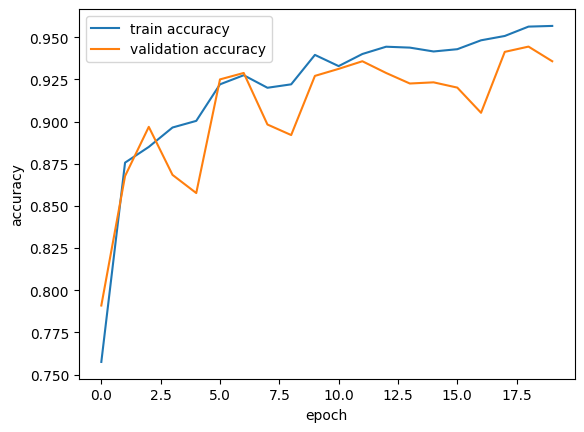

In [ ]:
showCharts(train_history, val_history, mode='acc')

WandB chart

In [ ]:
IPython.display.HTML('<iframe src="https://api.wandb.ai/links/amirezzati/ek2u2kxe" style="border:none;height:512px;width:1024px">')

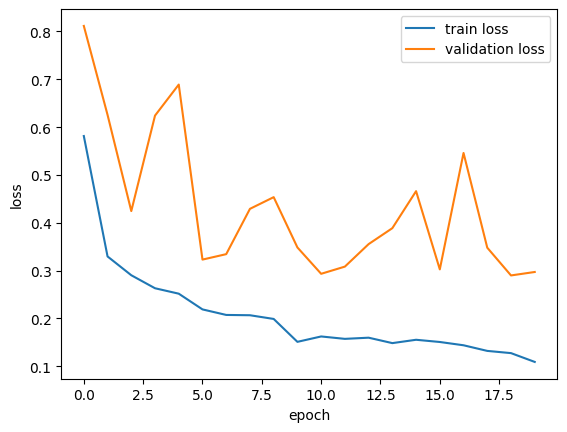

In [ ]:
showCharts(train_history, val_history, mode='loss')

WandB chart

In [ ]:
IPython.display.HTML('<iframe src="https://api.wandb.ai/links/amirezzati/pvtxm8yo" style="border:none;height:512px;width:1024px">')

## evaluate the model

In [ ]:
model_path = data_path[:-5] + 'alexnet_t.pt'
alexnet_t = torch.load(model_path)

**in Trainset**


Loss: 0.0592 - ACC: 0.9903% - Precision: 0.9911% - Recall 0.9903% - F1 score: 0.99%


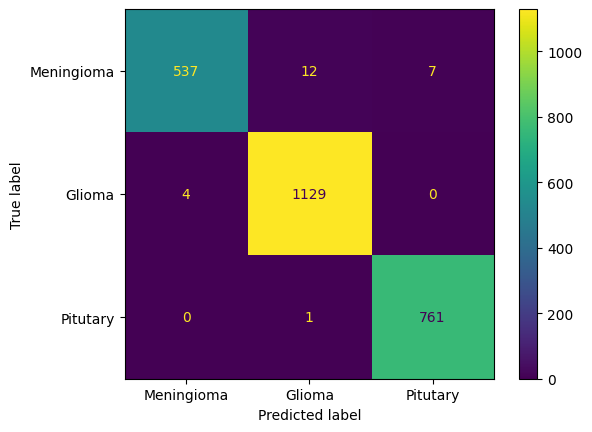

In [ ]:
evaluate(alexnet_t, train_dataloader, criterion, device)
confusionMatrix(alexnet_t, train_dataloader, device)

**in Validationset**


In [ ]:
evaluate(alexnet_t, val_dataloader, criterion, device)
confusionMatrix(alexnet_t, val_dataloader, device)

**in Testset**


Loss: 0.4500 - ACC: 0.9322% - Precision: 0.9371% - Recall 0.9322% - F1 score: 0.93%


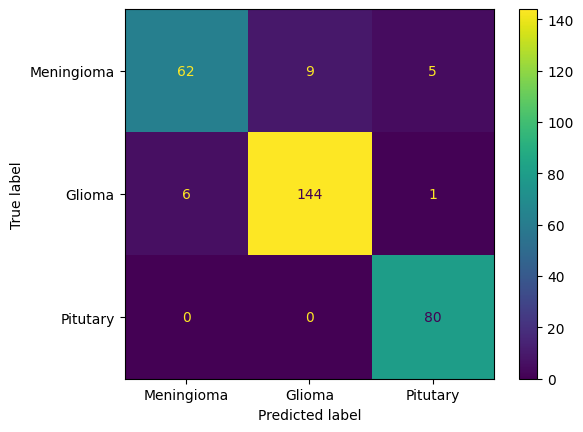

In [ ]:
evaluate(alexnet_t, test_dataloader, criterion, device)
confusionMatrix(alexnet_t, test_dataloader, device)

# AlexNet (10 epochs with supervised contrastive loss - 5 epochs with cross entropy)

## modified train procedure and transform of dataset for this section

**Two crop Transform**

In [17]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

## Supervised Contrastive loss

In [18]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn


class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf."""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

## Create Dataset

In [19]:
transform = t.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomGrayscale(p=0.2),
    torchvision.transforms.ToTensor(),
])

train_dataset = DatasetPair(trainset[:, 0], trainset[:, 1], twoCropTransform=TwoCropTransform(transform))
val_dataset = DatasetPair(valset[:, 0], valset[:, 1], twoCropTransform=TwoCropTransform(transform))
test_dataset = DatasetPair(testset[:, 0], testset[:, 1], twoCropTransform=TwoCropTransform(transform))

In [20]:
print('sample 0: ', type(train_dataset[0]))
print('sample 0 num of images: ', len(train_dataset[0][0]))
print('sample 0 shape of each image: ', train_dataset[0][0][0].shape)

sample 0:  <class 'tuple'>
sample 0 num of images:  2
sample 0 shape of each image:  torch.Size([3, 512, 512])



## Encoder ( AlexNet )

In [23]:
class AlexNetEncoder(nn.Module):
    def __init__(self, feat_dim = 50):
        super(AlexNetEncoder, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.encoder = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024), # (4096, 4096) --> (4096, 1024) to avoid overfitting and heavy losses during training
            nn.ReLU(inplace=True),
            nn.Linear(1024, feat_dim),
        )

    def forward(self, x):
      x = self.features(x)
      x = self.avgpool(x)
      x = x.view(-1, 256 * 6 * 6)
      x = self.encoder(x)
      return x

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# create model
alexnet_encoder = AlexNetEncoder(feat_dim = 50).to(device)

In [25]:
BATCH_SIZE = 32
lr = 1e-3

optimizer = optim.Adam(alexnet_encoder.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)

val_dataloader = DataLoader(
        val_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)

test_dataloader = DataLoader(
        test_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)

In [26]:
def train_one_epoch_encoder(model, loader, criterion, optimizer, history, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(loader):
        inputs, labels = data[0], data[1].to(device)

        inputs = torch.cat([inputs[0], inputs[1]], dim=0).to(device)

        optimizer.zero_grad()
        features = model(inputs)

        bsz = labels.shape[0]
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

        loss = criterion(features, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss = running_loss / len(loader)

    history['loss'].append(loss)
    return loss

def validate_one_epoch_encoder(model, loader, criterion, history, device):
    model.eval()

    running_loss = 0.0
    running_accuracy = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1_score = 0.0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0], data[1].to(device)
            inputs = torch.cat([inputs[0], inputs[1]], dim=0).to(device)

            features = model(inputs)

            bsz = labels.shape[0]
            f1, f2 = torch.split(features, [bsz, bsz], dim=0)
            features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

            loss = criterion(features, labels)
            running_loss += loss.item()

            running_loss += loss.item()

    loss = running_loss / len(loader)

    history['loss'].append(loss)
    return loss

In [27]:
def train_encoder(epochs, model, train_dataloader, val_dataloader, criterion, optimizer, train_history, val_history, model_path, device, best_valid_loss = math.inf):
  for epoch in range(epochs):
    train_loss = train_one_epoch_encoder(model, train_dataloader, criterion, optimizer, train_history, device)
    val_loss = validate_one_epoch_encoder(model, val_dataloader, criterion, val_history, device)

    wandb.log({"train_loss": train_loss, "val_loss": val_loss})

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model, model_path)

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f} - "
          f"Validation Loss: {val_loss:.4f} - ")
  return best_valid_loss

In [ ]:
num_epochs = 15

wandb.init(
    # set the wandb project where this run will be logged
    project="Brain MRI Classification",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "alexnet_encoder",
    "epochs": num_epochs,
    },
    name='alexnet_encoder'
)


train_history = {'loss': []}
val_history = {'loss': []}

model_path = data_path[:-5] + 'alexnet_encoder.pt'
best_valid_loss = math.inf

criterion = SupConLoss()
firt_best_loss = train_encoder(10, alexnet_encoder, train_dataloader, val_dataloader, criterion, optimizer, train_history, val_history, model_path, device, best_valid_loss = best_valid_loss)


# criterion = nn.CrossEntropyLoss()
# second_best_loss = train(5, alexnet_2losses, train_dataloader, val_dataloader, criterion, optimizer, train_history, val_history, model_path, device, best_valid_loss = firt_best_loss)

wandb.finish()

wandb: Currently logged in as: amirezzati. Use `wandb login --relogin` to force relogin


Epoch [1/10] - Train Loss: 4.0496 - Validation Loss: 7.9181 - 
Epoch [2/10] - Train Loss: 3.9727 - Validation Loss: 8.0604 - 
Epoch [3/10] - Train Loss: 3.9282 - Validation Loss: 7.6164 - 


## Classifier ( Linear )

In [ ]:
class Classifier(nn.Module):
    def __init__(self, num_classes = 3):
        super(Classifier, self).__init__()
        self.encoder = torch.load(data_path[:-5] + 'alexnet_encoder.pt')

        for layer_name, layer in self.encoder.named_parameters():
          layer.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(50, num_classes),
        )

    def forward(self, x):
      x = self.encoder(x)
      x = self.classifier(x)
      return x

In [ ]:
c = Classifier(3)
c

In [ ]:
for layer_name, layer in c.named_parameters():
  if layer.requires_grad:
    print(layer_name)